In [ ]:
!pip install torch-summary
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-3-6530242ea47a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'cuda'

In [ ]:
PATH = '/content/drive/MyDrive/eye'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
4143,/content/drive/MyDrive/eye/normal/1034_left.jpg,3
2122,/content/drive/MyDrive/eye/diabetic_retinopath...,1
3257,/content/drive/MyDrive/eye/normal/2524_left.jpg,3
3055,/content/drive/MyDrive/eye/glaucoma/_48_368453...,2
3218,/content/drive/MyDrive/eye/normal/2485_right.jpg,3


<ipython-input-5-949d57b1b1b9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

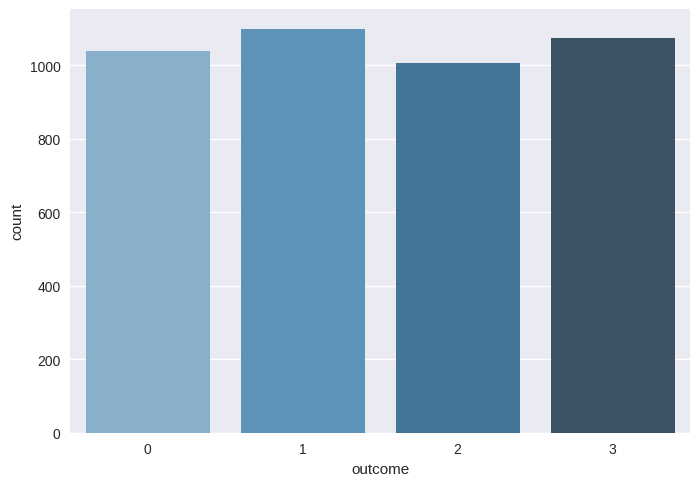

In [ ]:
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')

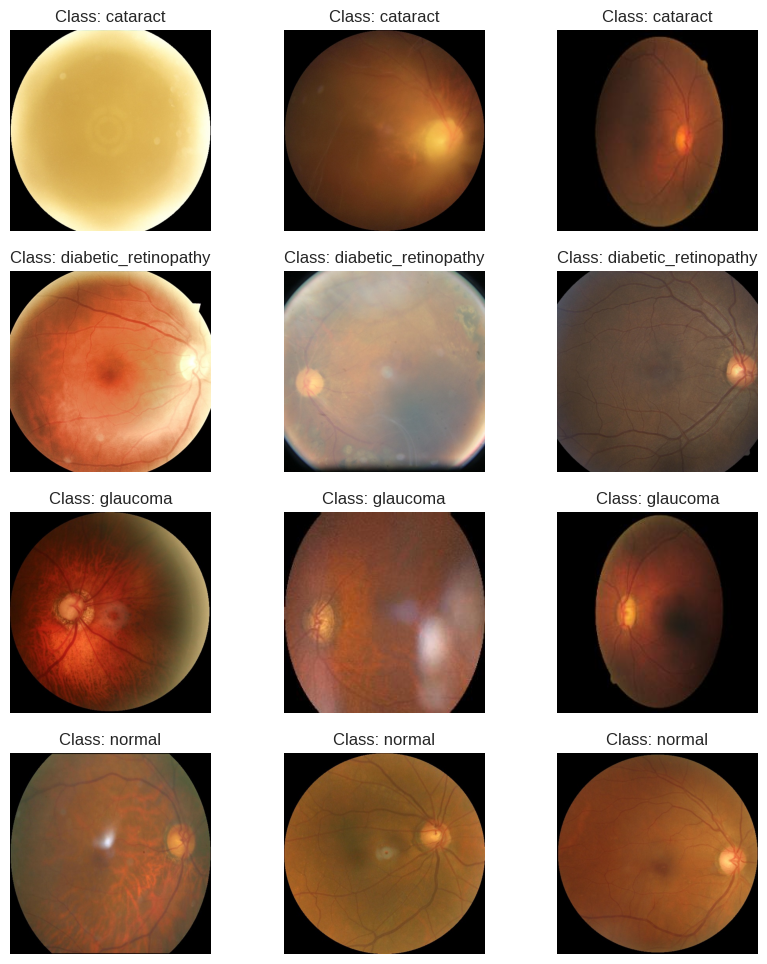

In [ ]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min())/img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

In [ ]:
NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [ ]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained = True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()


    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x



class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)

        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))

In [ ]:
trainer = Trainer(train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(trainer.model.base, (3, 224, 224))

In [ ]:
trainer.train(epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.771 acc: 0.696] Val: [loss: 0.528 acc:0.798]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.399 acc: 0.843] Val: [loss: 0.325 acc:0.890]


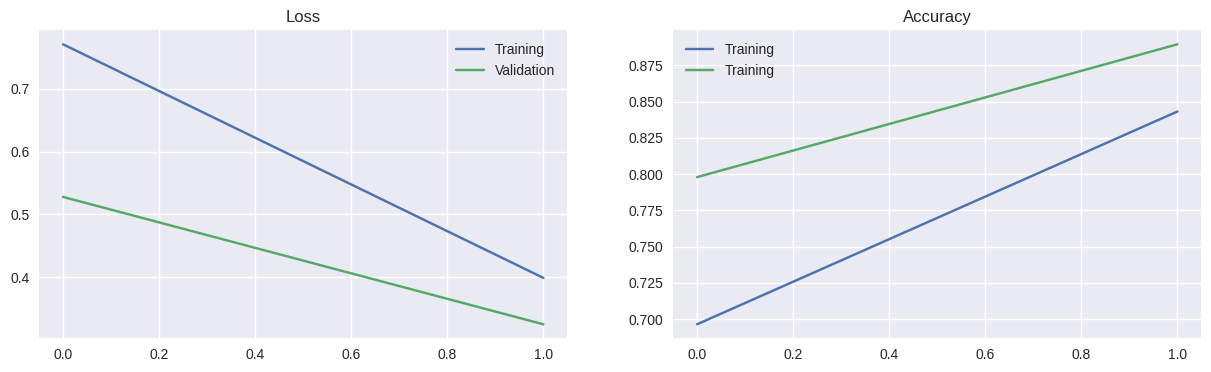

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()

In [ ]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

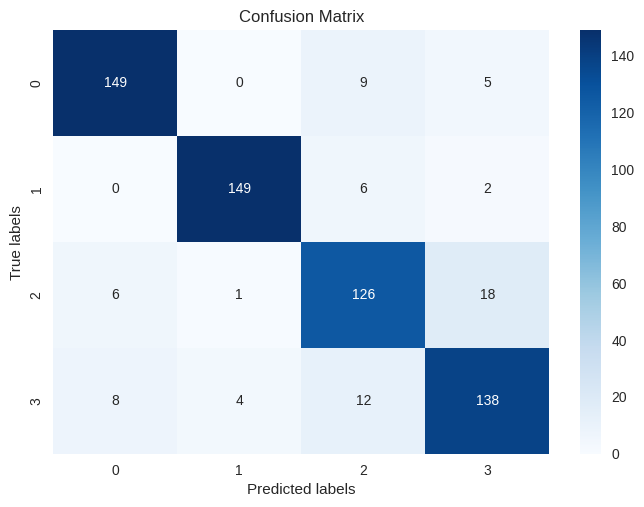

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.91      0.91      0.91       163
diabetic_retinopathy       0.97      0.95      0.96       157
            glaucoma       0.82      0.83      0.83       151
              normal       0.85      0.85      0.85       162

            accuracy                           0.89       633
           macro avg       0.89      0.89      0.89       633
        weighted avg       0.89      0.89      0.89       633



AlexNet

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Corrected output size
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = AlexNet(num_classes=NUM_CLASSES)  # Ensure correct number of classes
        self.block = nn.Sequential(
            nn.Linear(NUM_CLASSES, 128),  # Update input size to match the number of classes
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUM_CLASSES),
        )

    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params': self.base.parameters(), 'lr': 3e-5},
            {'params': self.block.parameters(), 'lr': 8e-4}
        ])

    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x


In [ ]:
trainer = Trainer(train_loader, val_loader, device)

In [ ]:
summary(trainer.model.base, (3, 224, 224))

In [ ]:
trainer.train(epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 1.387 acc: 0.252] Val: [loss: 1.382 acc:0.278]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 1.375 acc: 0.285] Val: [loss: 1.359 acc:0.304]


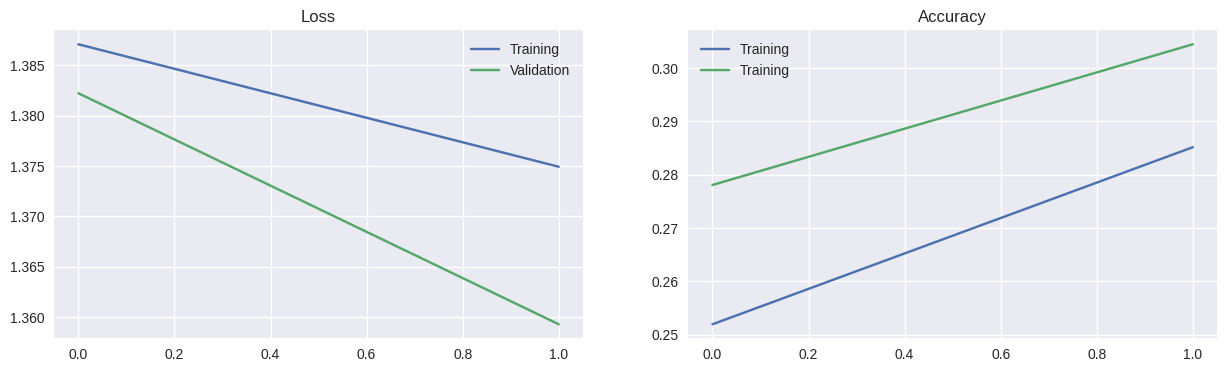

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()

In [ ]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

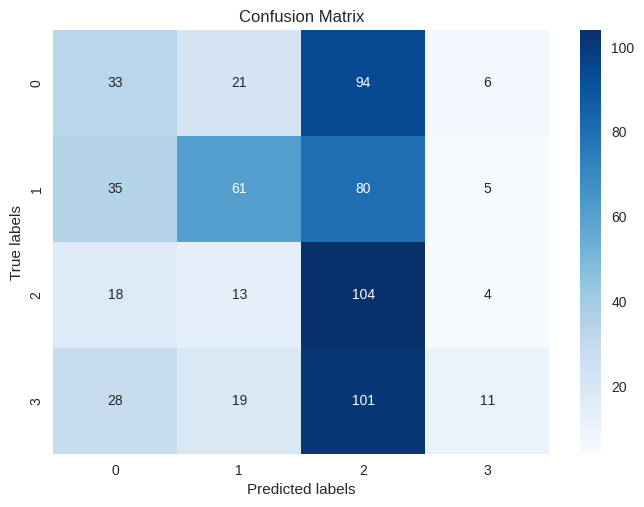

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.29      0.21      0.25       154
diabetic_retinopathy       0.54      0.34      0.41       181
            glaucoma       0.27      0.75      0.40       139
              normal       0.42      0.07      0.12       159

            accuracy                           0.33       633
           macro avg       0.38      0.34      0.30       633
        weighted avg       0.39      0.33      0.30       633



GoggleNet

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.base = models.vgg19(pretrained=True)
        self.base.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.base(x)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.base = models.googlenet(pretrained=True)
        num_features = self.base.fc.in_features
        self.base.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base(x)

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device, num_classes):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net(num_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)  # Define optimizer here
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(self.device)

        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))



In [ ]:
trainer = Trainer(train_loader, val_loader, device, num_classes=NUM_CLASSES)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 83.6MB/s]


In [ ]:
summary(trainer.model.base, (3, 224, 224))

In [ ]:
trainer.train(epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.495 acc: 0.812] Val: [loss: 0.223 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.214 acc: 0.920] Val: [loss: 0.195 acc:0.929]


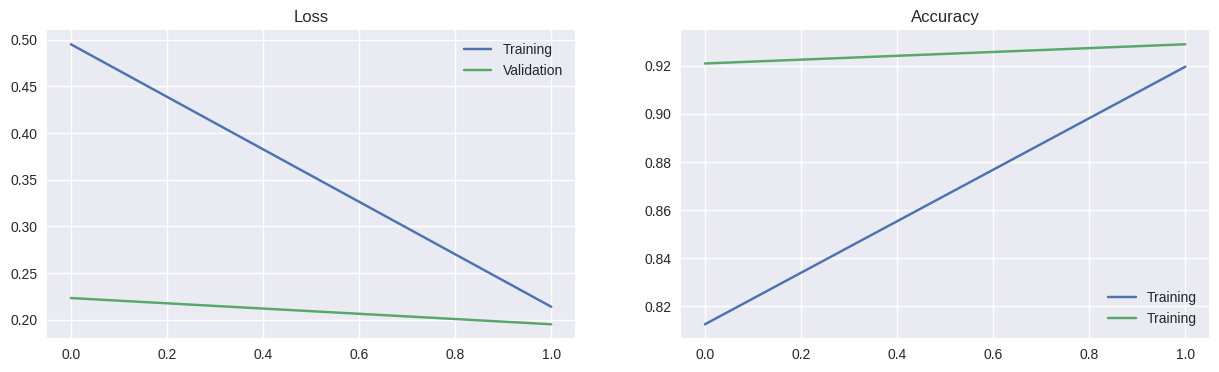

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()

In [ ]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

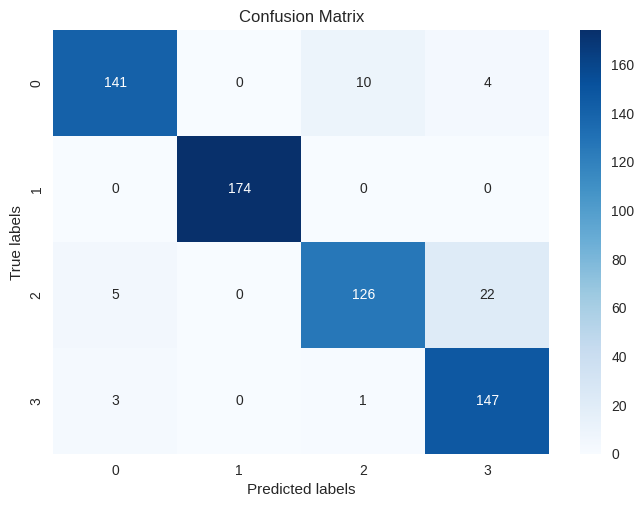

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.95      0.91      0.93       155
diabetic_retinopathy       1.00      1.00      1.00       174
            glaucoma       0.92      0.82      0.87       153
              normal       0.85      0.97      0.91       151

            accuracy                           0.93       633
           macro avg       0.93      0.93      0.93       633
        weighted avg       0.93      0.93      0.93       633



ResNet50

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.base = models.resnet50(pretrained=True)
        # Modify the last layer for the number of classes in your task
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device, num_classes):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = ResNet50(num_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(self.device)

        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [ ]:
trainer = Trainer(train_loader, val_loader, device, num_classes=NUM_CLASSES)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


In [ ]:
summary(trainer.model.base, (3, 224, 224))

In [ ]:
trainer.train(epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.411 acc: 0.833] Val: [loss: 0.194 acc:0.928]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.196 acc: 0.928] Val: [loss: 0.190 acc:0.935]


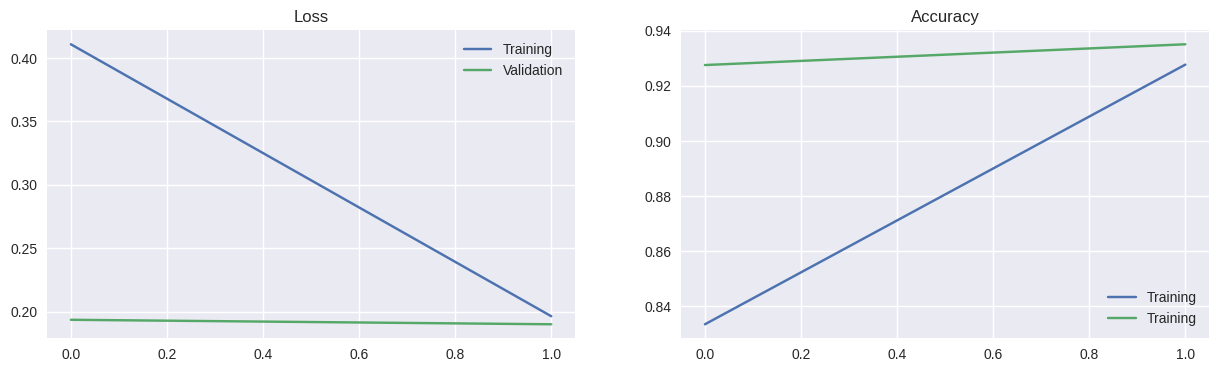

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()

In [ ]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

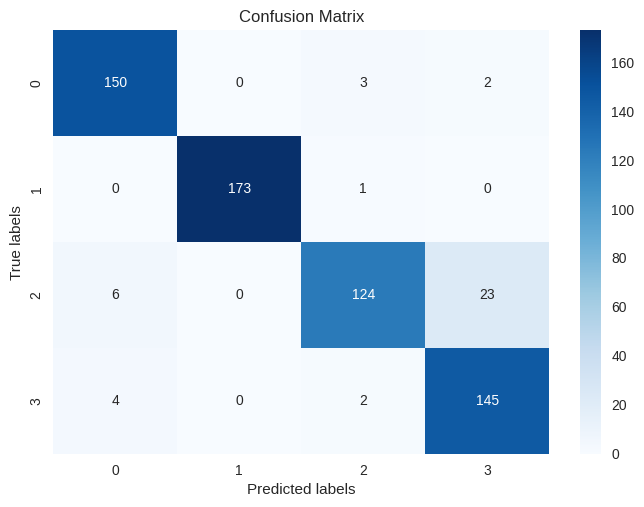

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.94      0.97      0.95       155
diabetic_retinopathy       1.00      0.99      1.00       174
            glaucoma       0.95      0.81      0.88       153
              normal       0.85      0.96      0.90       151

            accuracy                           0.94       633
           macro avg       0.94      0.93      0.93       633
        weighted avg       0.94      0.94      0.93       633



VGG19

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()
        self.base = models.vgg19(pretrained=True)
        # Modify the last layer for the number of classes in your task
        self.base.classifier[6] = nn.Linear(self.base.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.base(x)

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device, num_classes):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = VGG19(num_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(self.device)

        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [ ]:
trainer = Trainer(train_loader, val_loader, device, num_classes=NUM_CLASSES)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 56.2MB/s]


In [ ]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [ ]:
trainer.train(epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 1.133 acc: 0.491] Val: [loss: 1.011 acc:0.697]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.479 acc: 0.835] Val: [loss: 0.433 acc:0.858]


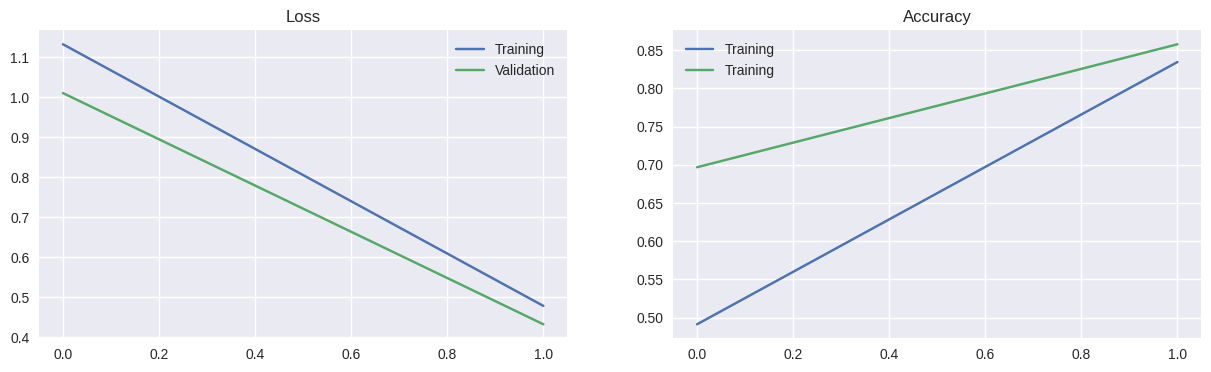

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()

In [ ]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

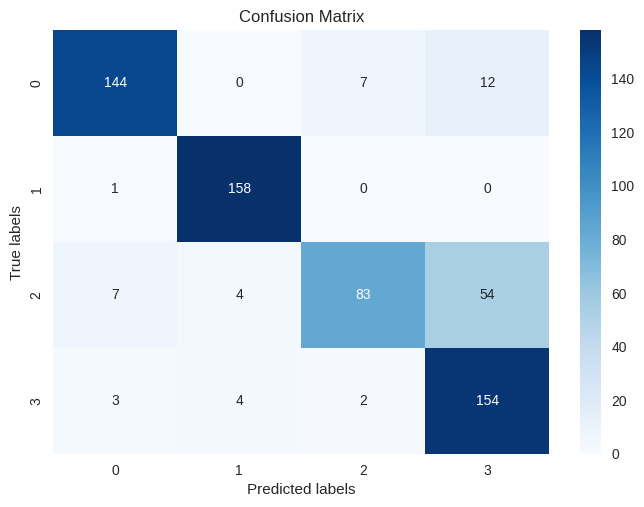

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.93      0.88      0.91       163
diabetic_retinopathy       0.95      0.99      0.97       159
            glaucoma       0.90      0.56      0.69       148
              normal       0.70      0.94      0.80       163

            accuracy                           0.85       633
           macro avg       0.87      0.85      0.84       633
        weighted avg       0.87      0.85      0.85       633

